In [0]:
# Importing the required Libraries
import os
import cv2
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Mounting Google Drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Changing Current Working Directory
os.chdir("drive/My Drive/Colab Notebooks/Lane Detection")

In [4]:
# Checking the Current Working Directory
!pwd

/content/drive/My Drive/Colab Notebooks/Lane Detection


Image Shape =  (704, 1279, 3)


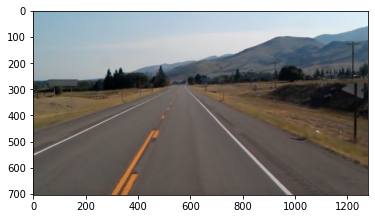

In [5]:
# Reading Image from the directory
img = plt.imread("test_image.jpg")[..., :-1]
lane_img = np.copy(img)
print("Image Shape = ", img.shape)
plt.imshow(img)
plt.show()

In [0]:
# Canny Edge Detection
def canny(image):
  # Canny Edge Detection Requires Grayscale Image
  image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  # Gaussian Blurring
  image = cv2.GaussianBlur(image, (5, 5), 0)

  # Canny Edge Detection
  image = cv2.Canny(image, 50, 150)

  return image

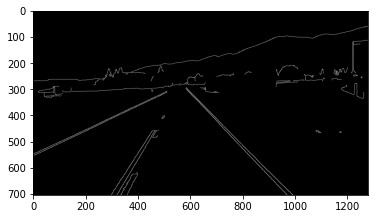

In [7]:
# Canny Edge Detection
canny_image = canny(lane_img)

plt.imshow(canny_image, cmap = "gray")
plt.show()

In [0]:
# Defining the region of interest(ROI)
# Masking the background information except roads
def region_of_interest(image):
  # Retrieving the height of the image
  height = image.shape[0]

  # Masks with zeros array
  mask = np.zeros_like(image)

  # The required roi looks like a triangle
  triangle = np.array([[(250, height),
                        (550, 250),
                        (1050, height)]], dtype = np.int32)
  
  # Filling the mask with value 255
  cv2.fillPoly(mask, triangle, 255)

  # Bitwise AND between image and mask
  masked_image = cv2.bitwise_and(image, mask)

  return masked_image

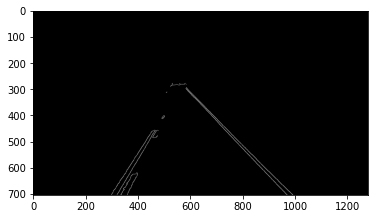

In [9]:
# Region of Interest (ROI)
roi_image = region_of_interest(canny_image)

plt.imshow(roi_image, cmap = "gray")
plt.show()

In [0]:
lines = cv2.HoughLinesP(roi_image, 2, np.pi / 180, 100, np.array([]), minLineLength = 40, maxLineGap = 5)

In [11]:
lines.shape

(14, 1, 4)

In [0]:
def display_lines(image, lines):
  line_image = np.zeros_like(image)
  if lines is not None:
    for line in lines:
      x1, y1, x2, y2 = line.reshape(4)
      cv2.line(line_image, (x1, y1), (x2, y2), color = (0, 0, 255), thickness = 10)
  return line_image

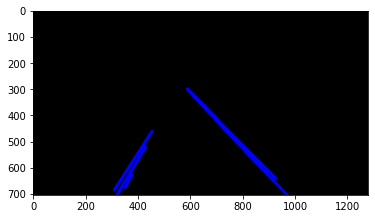

In [13]:
lines_image = display_lines(lane_img, lines)
plt.imshow(lines_image, cmap = "gray")
plt.show()

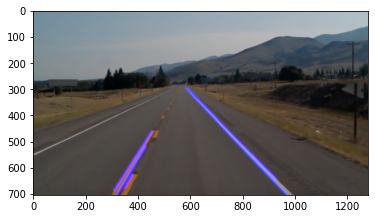

In [14]:
combo_image = cv2.addWeighted(lane_img, 0.8, lines_image, 1, 1)
plt.imshow(combo_image)
plt.show()

In [0]:
# Function which returns the two point co-ordinates of a line
# Given the image and line slope and intercept

def make_coordinates(image, line):
  slope, intercept = line

  # Height(Bottom) of the image
  y1 = int(image.shape[0])

  # Slightly Lower than the middle of the image
  y2 = int(y1 * 3 / 5)

  # Calculating X from Y
  # Y = mX + C (or) Y = slope.X + intercept
  # X = (Y - intercept) / slope
  x1 = (y1 - intercept) / slope
  x2 = (y2 - intercept) / slope

  return np.array([x1, y1, x2, y2])

In [0]:
# We can see that there are many lane lines
# We can smooth them out by taking their average
def average_slope_intercept(image, lines):

  # Empty lists to latter append left and right lane lines
  left_fit = []
  right_fit = []

  # If there are no lines detected
  # We are going to return None
  if lines is None:
    return None
  
  for line in lines:

    x1, y1, x2, y2 = line.reshape(4)

    # Fitting a Single degree polynomial
    # Or Solving a line equation from the points
    # To get the slope and intercept for the corresponding line
    fit = np.polyfit((x1, x2), (y1, y2), 1)

    # Slope
    slope = fit[0]
    
    # Intercept
    intercept = fit[1]

    # Positive Slope : Two Variables are positively related
    # In our case as X increases, y increases or as y increases x increases
    # The right side lane has positive slope

    # Negative Slope : Two Variables are negatively related
    # In our case as X increases, y decreases or as y increases x decreases
    # The left side lane has negative slope

    if slope < 0:
      left_fit.append((slope, intercept))
    else:
      right_fit.append((slope, intercept))

  # Smoothed out lines
  left_fit_average = np.average(left_fit, axis = 0)
  right_fit_average = np.average(right_fit, axis = 0)

  # The coordinates of lines are obtained from make_coordinates function
  left_line = make_coordinates(image, left_fit_average)
  right_line = make_coordinates(image, right_fit_average)

  averaged_lines = np.array([left_line, right_line], dtype = np.int32)

  return averaged_lines

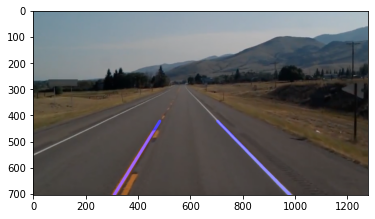

In [17]:
# Smoothes out lane lines
averaged_lines = average_slope_intercept(lane_img, lines)

# Draws the lane lines into the input image
line_img = display_lines(lane_img, averaged_lines)

# Weighted addition of two images
combo_image = cv2.addWeighted(lane_img, 0.8, line_img, 1, 1)

# Visualzing the output image
plt.imshow(combo_image)
plt.show()